In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements(is_chapter6=True)

In [1]:
#hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v2.14.6


In [2]:
# hide
from transformers import pipeline, set_seed

2024-04-03 17:32:42.143879: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 17:32:42.173233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 17:32:42.743278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Summarization

## The CNN/DailyMail Dataset

In [4]:
#hide_output
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features: ['article', 'highlights', 'id']


/home/rohara/anaconda3/envs/hf_book/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay. The fastest man in the world charged clear of United States rival Justin
Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel
Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds
with Canada taking the bronze after Britain were disqualified for a faulty
handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


## Text Summarization Pipelines

In [6]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [7]:
#hide_output
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/rohara/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline


In [9]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [10]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [11]:
#hide_output
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="images/chapter08_t5.png" id="T5"/>

In [12]:
#hide_output
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

### BART

In [13]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="images/chapter08_pegasus.png" id="pegasus"/>

In [14]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## Comparing Different Summaries

In [15]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay.
The fastest man in the world charged clear of United States rival Justin Gatlin
as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and
Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after
Britain were disqualified for a faulty handover.

GPT2
Usain Bolt won a record fourth gold medal of the London 2012 Olympics, taking
the gold of the men's 4x100m relay.
Usain Bolt was the only athlete to win an Olympic event in three consecutive
Games, having done so twice before in the 100m and 110m hurdles.
Usain Bolt clocked a blistering time of 37.42 seconds at the

## Measuring the Quality of Generated Text

### BLEU

In [16]:
# hide_output
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

/tmp/ipykernel_45333/2973086757.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [17]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [18]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [19]:
# hide_output
rouge_metric = load_metric("rouge")

In [20]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.285714,0.112360,0.197802,0.263736
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [22]:
# hide
# ignore this cell it is only to be able to start running the notebook here
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/home/rohara/anaconda3/envs/hf_book/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [23]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [24]:
test_sampled = dataset["train"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.255041,0.102389,0.166558,0.232592


In [25]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [26]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 125/125 [07:50<00:00,  3.76s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.488557,0.295959,0.391597,0.441505


In [27]:
# hide_input 
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.488557,0.295959,0.391597,0.441505


## Training a Summarization Model

In [28]:
# hide_output
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [29]:
# hide_input
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### Evaluating PEGASUS on SAMSum

In [30]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [31]:
# hide_output
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [06:10<00:00,  3.60s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


In [32]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


### Fine-Tuning PEGASUS

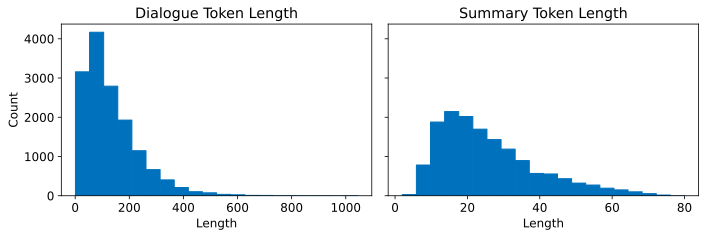

In [33]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [34]:
#hide_output
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [35]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [36]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [37]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=False,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [38]:
# #hide_output
# from huggingface_hub import notebook_login

# notebook_login()

In [39]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [40]:
# hide_output
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id.
/home/rohara/anaconda3/envs/hf_book/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920


{'loss': 3.3157, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 2.8532, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.0664, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.8314, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.77, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.9383, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.6805, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.3618, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.4355, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.3458, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.3254, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.136, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.2566, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.2137, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.1431, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.1262, 'learning_

The following columns in the evaluation set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


{'loss': 1.6933, 'learning_rate': 5e-05, 'epoch': 0.54}
{'eval_loss': 1.490547776222229, 'eval_runtime': 12.3935, 'eval_samples_per_second': 66.002, 'eval_steps_per_second': 66.002, 'epoch': 0.54}
{'loss': 1.7176, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6396, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.7109, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.7066, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6916, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6048, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.5925, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.6082, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.6348, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.5642, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.6142, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.



Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 1.5697, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 1017.0733, 'train_samples_per_second': 14.485, 'train_steps_per_second': 0.905, 'train_loss': 1.8258739989736805, 'epoch': 1.0}


100%|██████████| 410/410 [04:13<00:00,  1.62it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427046,0.197602,0.340361,0.340649


In [41]:
# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427046,0.197602,0.340361,0.340649


In [42]:
# hide_output
# trainer.push_to_hub("Training complete!")

### Generating Dialogue Summaries

In [43]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [44]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Downloading:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.13G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [45]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.


## Conclusion